# Challenge Data ENS : Return Forecasting of Cryptocurrency Clusters (par Napoleon X)

---

## 1. Packages et paramètres

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import networkx as nx

# modélisation
import xgboost as xgb
from scipy.stats import skew, kurtosis
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import optuna

# paramètres de style pour les graphiques
plt.style.use("dark_background")

plt.rcParams.update({
    "grid.color": "#444444",
    "grid.alpha": 0.8,
    "grid.linestyle": "--", 
})

---

## 2. Data

### 2.1 Importation des données

In [2]:
x_train = pd.read_csv('input/input_train__fppJZ22.csv')
y_train = pd.read_csv('input/y_train_CGZ7jXu.csv')
x_test = pd.read_csv('input/input_test__2scdXsn.csv')
    
print("Taille de x_train :", x_train.shape)
print("Taille de y_train :", y_train.shape)

display(x_train.head(), y_train.head())

# Import de la matrice d'adjacence
with open("input/adjacency_matrices_pgWTvf5.pkl", "rb") as file:
    adj = pickle.load(file)

Taille de x_train : (491038, 29)
Taille de y_train : (30494, 2)


,id,cluster,day,asset,md,bc,ret_1,ret_2,ret_3,ret_4,...,ret_14,ret_15,ret_16,ret_17,ret_18,ret_19,ret_20,ret_21,ret_22,ret_23
0,0,0,17,10,-5.734573,0.125855,-0.002060,0.005848,-0.002736,-0.005487,...,NaN,-0.000339,0.001018,-0.002372,-0.000340,-0.000680,-0.007140,0.006849,0.002041,-0.001697
1,1,0,0,13,-5.813696,0.418711,-0.042280,-0.009460,-0.005173,-0.006000,...,0.004107,-0.005726,0.006993,-0.003268,0.015574,-0.010492,0.004486,0.011368,0.001606,0.000401
2,2,0,20,12,-5.814399,0.500111,0.003665,-0.010841,0.007557,0.004981,...,-0.000113,-0.000170,-0.002833,-0.007442,-0.001832,-0.005677,-0.007093,0.001626,0.004349,-0.004677
3,3,0,19,12,-5.814399,0.500111,-0.018364,0.003789,0.011795,0.016029,...,0.005604,-0.009794,-0.001023,-0.002959,0.002568,-0.005579,0.001317,-0.010005,0.004677,-0.004196
4,4,0,18,12,-5.814399,0.500111,-0.001589,0.011711,-0.010507,-0.002555,...,0.002530,-0.018505,-0.010855,0.002022,0.001211,-0.002648,0.001559,-0.001153,0.000635,0.001961


,sample_id,target
0,0,0.000301
1,1,-0.011966
2,2,-0.011395
3,3,0.000664
4,4,0.002852


### 2.2 Valeurs manquantes

In [3]:
missing_values_df = x_train.isnull().sum().reset_index()
missing_values_df.columns = ['Feature', 'Missing Values']
missing_values_df = missing_values_df[missing_values_df['Missing Values'] > 0]
missing_values_df = missing_values_df.sort_values(by='Missing Values', ascending=False).reset_index(drop=True)
display(missing_values_df)

,Feature,Missing Values
0,ret_20,28373
1,ret_19,28310
2,ret_4,28007
3,ret_21,27984
4,ret_22,27890
5,ret_6,27556
6,ret_7,26963
7,ret_18,26867
8,ret_5,26834
9,ret_23,26706


In [4]:
ret_cols = [f'ret_{i}' for i in range(1, 24)]

# Imputation des valeurs manquantes par interpolation linéaire
x_train.loc[:, ret_cols] = x_train.loc[:, ret_cols].T.interpolate(method='linear').T
x_test.loc[:, ret_cols] = x_test.loc[:, ret_cols].T.interpolate(method='linear').T

# Fallback : imputation par la médiane du cluster-jour
x_train.loc[:, ret_cols] = x_train.loc[:, ret_cols].fillna(
    x_train.groupby(['cluster', 'day'])[ret_cols].transform('median')
)
x_test.loc[:, ret_cols] = x_test.loc[:, ret_cols].fillna(
    x_test.groupby(['cluster', 'day'])[ret_cols].transform('median')
)

# Imputation des valeurs manquantes pour la colonne 'bc' par la médiane du cluster-jour
x_train['bc'] = x_train['bc'].fillna(
    x_train.groupby(['cluster', 'day'])['bc'].transform('median')
)
x_test['bc'] = x_test['bc'].fillna(
    x_test.groupby(['cluster', 'day'])['bc'].transform('median')
)

### 2.3 Features structurelles

In [5]:
def calculate_graph_features(df, adj_dict):
    df['node_degree'] = np.nan
    df['eigen_centrality'] = np.nan
    df['betweenness_centrality'] = np.nan
    
    # Boucler sur chaque cluster unique présent dans les données d'entraînement
    for cluster_id, cluster_df in df.groupby('cluster'):
        if cluster_id in adj_dict:
            # Récupérer la matrice d'adjacence pour ce cluster
            A = adj_dict[cluster_id]
            # Créer le graphe networkx
            G = nx.from_numpy_array(A)
            
            # Calculer les métriques
            degree = dict(G.degree())
            eigen_centrality = nx.eigenvector_centrality(G, max_iter=1000)
            betweenness_centrality = nx.betweenness_centrality(G)
            
            # Appliquer les résultats au DataFrame original (en utilisant l'index 'asset')
            # L'index 'asset' (0, 1, 2...) correspond ici aux indices des nœuds du graphe.
            node_map = cluster_df['asset'].unique() 
            
            for i, asset_id in enumerate(node_map):
                df.loc[cluster_df[cluster_df['asset'] == asset_id].index, 'node_degree'] = degree[i]
                df.loc[cluster_df[cluster_df['asset'] == asset_id].index, 'eigen_centrality'] = eigen_centrality[i]
                df.loc[cluster_df[cluster_df['asset'] == asset_id].index, 'betweenness_centrality'] = betweenness_centrality[i]

    return df

# xtrain
x_train_2 = calculate_graph_features(x_train, adj)

# xtest
x_test_2 = calculate_graph_features(x_test, adj)

# aperçu des nouvelles features
display(x_train_2[['cluster','day', 'asset', 'node_degree', 'eigen_centrality', 'betweenness_centrality']].head(10))

,cluster,day,asset,node_degree,eigen_centrality,betweenness_centrality
0,0,17,10,3.0,0.124844,0.215686
1,0,0,13,2.0,0.106924,0.209150
2,0,20,12,1.0,0.043783,0.000000
3,0,19,12,1.0,0.043783,0.000000
4,0,18,12,1.0,0.043783,0.000000
5,0,17,12,1.0,0.043783,0.000000
6,0,16,12,1.0,0.043783,0.000000
7,0,15,12,1.0,0.043783,0.000000
8,0,14,12,1.0,0.043783,0.000000
9,0,13,12,1.0,0.043783,0.000000


### 2.4 Features temporelles

In [6]:
ret_cols = [f'ret_{i}' for i in range(1, 24)]
last_ret = ['ret_21', 'ret_22', 'ret_23']

x_train_3 = x_train_2.copy()
x_test_3 = x_test_2.copy()

# tendance
x_train_3['ret_sum'] = x_train_2[ret_cols].sum(axis=1)
x_train_3['ret_mean'] = x_train_2[ret_cols].mean(axis=1)
x_train_3['ret_recent_mean'] = x_train_2[last_ret].mean(axis=1)
x_test_3['ret_sum'] = x_test_2[ret_cols].sum(axis=1)
x_test_3['ret_mean'] = x_test_2[ret_cols].mean(axis=1)
x_test_3['ret_recent_mean'] = x_test_2[last_ret].mean(axis=1)

# volatilité et risque
x_train_3['ret_std'] = x_train_2[ret_cols].std(axis=1)
x_train_3['ret_recent_std'] = x_train_2[last_ret].std(axis=1)
x_train_3['ret_max_abs'] = x_train_2[ret_cols].abs().max(axis=1)
x_train_3['ret_diff_start_end'] = x_train_2['ret_23'] - x_train_2['ret_1']
x_test_3['ret_std'] = x_test_2[ret_cols].std(axis=1)
x_test_3['ret_recent_std'] = x_test_2[last_ret].std(axis=1)
x_test_3['ret_max_abs'] = x_test_2[ret_cols].abs().max(axis=1)
x_test_3['ret_diff_start_end'] = x_test_2['ret_23'] - x_test_2['ret_1']


# forme de distribution (optimisation clé)
ret_values = x_train_2[ret_cols].values
x_train_3['ret_kurtosis'] = kurtosis(ret_values, axis=1, fisher=True)
x_train_3['ret_skew'] = skew(ret_values, axis=1)
ret_values = x_test_2[ret_cols].values
x_test_3['ret_kurtosis'] = kurtosis(ret_values, axis=1, fisher=True)
x_test_3['ret_skew'] = skew(ret_values, axis=1)

# affichage des données finales
print("Features temporelles et de risque ajoutées à x_train.")
print(x_train_3.columns)
display(x_train_3.head())

Features temporelles et de risque ajoutées à x_train.
Index(['id', 'cluster', 'day', 'asset', 'md', 'bc', 'ret_1', 'ret_2', 'ret_3',
       'ret_4', 'ret_5', 'ret_6', 'ret_7', 'ret_8', 'ret_9', 'ret_10',
       'ret_11', 'ret_12', 'ret_13', 'ret_14', 'ret_15', 'ret_16', 'ret_17',
       'ret_18', 'ret_19', 'ret_20', 'ret_21', 'ret_22', 'ret_23',
       'node_degree', 'eigen_centrality', 'betweenness_centrality', 'ret_sum',
       'ret_mean', 'ret_recent_mean', 'ret_std', 'ret_recent_std',
       'ret_max_abs', 'ret_diff_start_end', 'ret_kurtosis', 'ret_skew'],
      dtype='object')


,id,cluster,day,asset,md,bc,ret_1,ret_2,ret_3,ret_4,...,betweenness_centrality,ret_sum,ret_mean,ret_recent_mean,ret_std,ret_recent_std,ret_max_abs,ret_diff_start_end,ret_kurtosis,ret_skew
0,0,0,17,10,-5.734573,0.125855,-0.002060,0.005848,-0.002736,-0.005487,...,0.215686,0.013948,0.000606,0.002398,0.006418,0.004284,0.017845,0.000363,1.311102,0.285072
1,1,0,0,13,-5.813696,0.418711,-0.042280,-0.009460,-0.005173,-0.006000,...,0.209150,-0.057649,-0.002506,0.004458,0.012580,0.006014,0.042280,0.042681,2.572392,-1.427823
2,2,0,20,12,-5.814399,0.500111,0.003665,-0.010841,0.007557,0.004981,...,0.000000,-0.012499,-0.000543,0.000433,0.005645,0.004630,0.011399,-0.008342,-0.764790,0.108252
3,3,0,19,12,-5.814399,0.500111,-0.018364,0.003789,0.011795,0.016029,...,0.000000,0.007558,0.000329,-0.003174,0.008430,0.007394,0.018384,0.014168,0.174211,0.177913
4,4,0,18,12,-5.814399,0.500111,-0.001589,0.011711,-0.010507,-0.002555,...,0.000000,-0.013068,-0.000568,0.000481,0.008918,0.001562,0.022431,0.003550,0.600029,0.339542


### 2.5 Aggrégation des données

In [7]:
# -- x_train ---

# Colonnes à aggréger pondérément par la centralité
TREND_COLS = ['ret_1', 'ret_2', 'ret_3', 'ret_4', 'ret_5', 'ret_6', 'ret_7', 'ret_8', 'ret_9', 'ret_10',
    'ret_11', 'ret_12', 'ret_13', 'ret_14', 'ret_15', 'ret_16', 'ret_17', 'ret_18', 'ret_19',
    'ret_20', 'ret_21', 'ret_22', 'ret_23', 'ret_sum', 'ret_mean', 'ret_recent_mean', 
    'ret_diff_start_end']

# Colonnes à agréger avec des statistiques descriptives
RISK_STRUCT_COLS = [
    'md', 'bc', 'node_degree', 'betweenness_centrality', 
    'ret_std', 'ret_recent_std', 'ret_max_abs', 
    'ret_kurtosis', 'ret_skew']

for col in TREND_COLS:
    x_train_3[f'{col}_weighted'] = x_train_3[col] * x_train_3['eigen_centrality']

agg_funcs = {
    **{f'{col}_weighted': 'sum' for col in TREND_COLS},
    'eigen_centrality': 'sum', 
    **{col: ['mean', 'std', 'max', 'min', 'median'] for col in RISK_STRUCT_COLS}
}

x_train_agg = x_train_3.groupby(['cluster', 'day']).agg(agg_funcs)

x_train_agg.columns = ['_'.join(col).strip() for col in x_train_agg.columns.values]
x_train_agg = x_train_agg.reset_index()

# Calcul de la moyenne pondérée finale : Numérateur / Dénominateur pour les colonnes de TREND_COLS
for col in TREND_COLS:
    numerator_col = f'{col}_weighted_sum'
    x_train_agg[f'{col}_weighted_mean'] = x_train_agg[numerator_col] / x_train_agg['eigen_centrality_sum']
    x_train_agg = x_train_agg.drop(columns=[numerator_col]) 

x_train_agg = x_train_agg.rename(columns={'eigen_centrality_sum': 'total_centrality_sum'})

x_train_agg['sample_id'] = x_train_agg['cluster'] * 21 + x_train_agg['day']
x_train_final = x_train_agg.drop(columns=['cluster', 'day'])
x_train_final = x_train_final.drop(columns=['id', 'asset'], errors='ignore')

cols = x_train_final.columns.tolist()
cols.insert(0, cols.pop(cols.index('sample_id')))
x_train_final = x_train_final[cols]

print(len(x_train_final))
display(x_train_final.tail(10))

30494


,sample_id,total_centrality_sum,md_mean,md_std,md_max,md_min,md_median,bc_mean,bc_std,bc_max,...,ret_18_weighted_mean,ret_19_weighted_mean,ret_20_weighted_mean,ret_21_weighted_mean,ret_22_weighted_mean,ret_23_weighted_mean,ret_sum_weighted_mean,ret_mean_weighted_mean,ret_recent_mean_weighted_mean,ret_diff_start_end_weighted_mean
30484,30734,2.312814,-6.751337,1.651018,-4.214598,-8.447019,-6.976589,0.471494,0.181586,0.634066,...,-6.500235e-03,0.004281,0.005718,-0.009034,0.016939,0.023750,0.052840,0.002297,0.010552,0.017414
30485,30735,2.312814,-6.751337,1.651018,-4.214598,-8.447019,-6.976589,0.471494,0.181586,0.634066,...,-2.677349e-03,0.026991,0.016029,-0.015080,-0.001480,0.010598,0.036690,0.001595,-0.001987,0.019528
30486,30736,2.312814,-6.751337,1.651018,-4.214598,-8.447019,-6.976589,0.471494,0.181586,0.634066,...,1.084745e-02,0.007082,0.021189,0.012279,-0.022552,0.006165,0.005583,0.000243,-0.001369,0.002461
30487,30737,2.312814,-6.751337,1.651018,-4.214598,-8.447019,-6.976589,0.471494,0.181586,0.634066,...,8.693990e-03,0.005143,-0.001994,-0.007928,-0.003193,0.015412,0.026113,0.001135,0.001430,0.011871
30488,30738,2.312814,-6.751337,1.651018,-4.214598,-8.447019,-6.976589,0.471494,0.181586,0.634066,...,1.177221e-02,0.002064,-0.007467,-0.003995,-0.000287,-0.013009,-0.023898,-0.001039,-0.005763,-0.013638
30489,30739,2.312814,-6.751337,1.651018,-4.214598,-8.447019,-6.976589,0.471494,0.181586,0.634066,...,-5.354523e-07,-0.001402,0.003960,0.013650,0.014763,-0.005937,-0.054584,-0.002373,0.007492,0.014370
30490,30740,2.312814,-6.751337,1.651018,-4.214598,-8.447019,-6.976589,0.471494,0.181586,0.634066,...,-8.567922e-04,-0.005075,-0.007698,0.008909,-0.009782,-0.006606,-0.018084,-0.000786,-0.002493,-0.000403
30491,30741,2.312814,-6.751337,1.651018,-4.214598,-8.447019,-6.976589,0.471494,0.181586,0.634066,...,4.957349e-03,0.005842,0.026345,0.005196,0.005375,-0.004639,0.061316,0.002666,0.001978,-0.014302
30492,30742,2.312814,-6.751337,1.651018,-4.214598,-8.447019,-6.976589,0.471494,0.181586,0.634066,...,1.745312e-03,-0.000679,0.003065,-0.006980,-0.005149,-0.001753,-0.009802,-0.000426,-0.004628,-0.006253
30493,30743,2.312814,-6.751337,1.651018,-4.214598,-8.447019,-6.976589,0.471494,0.181586,0.634066,...,-3.431040e-05,-0.002402,0.008416,-0.010385,-0.002160,0.006147,0.001548,0.000067,-0.002133,0.013088


In [8]:
# --- x_test ---

for col in TREND_COLS:
    x_test_3[f'{col}_weighted'] = x_test_3[col] * x_test_3['eigen_centrality']  

agg_funcs = {
    **{f'{col}_weighted': 'sum' for col in TREND_COLS},
    'eigen_centrality': 'sum', 
    **{col: ['mean', 'std', 'max', 'min', 'median'] for col in RISK_STRUCT_COLS}
}

x_test_agg = x_test_3.groupby(['cluster', 'day']).agg(agg_funcs)

x_test_agg.columns = ['_'.join(col).strip() for col in x_test_agg.columns.values]
x_test_agg = x_test_agg.reset_index()

# Calcul de la moyenne pondérée finale : Numérateur / Dénominateur pour les colonnes de TREND_COLS
for col in TREND_COLS:
    numerator_col = f'{col}_weighted_sum'
    denominator_col = 'eigen_centrality_sum'    
    x_test_agg[f'{col}_weighted_mean'] = x_test_agg[numerator_col] / x_test_agg[denominator_col]
    x_test_agg = x_test_agg.drop(columns=[numerator_col])

x_test_agg = x_test_agg.rename(columns={'eigen_centrality_sum': 'total_centrality_sum'})

x_test_agg['sample_id'] = x_test_agg['cluster'] * 21 + x_test_agg['day']
x_test_final = x_test_agg.drop(columns=['cluster', 'day'])
x_test_final = x_test_final.drop(columns=['id', 'asset'], errors='ignore')

cols = x_test_final.columns.tolist()
cols.insert(0, cols.pop(cols.index('sample_id')))
x_test_final = x_test_final[cols]

print(len(x_test_final))
display(x_test_final.tail(10))

13133


,sample_id,total_centrality_sum,md_mean,md_std,md_max,md_min,md_median,bc_mean,bc_std,bc_max,...,ret_18_weighted_mean,ret_19_weighted_mean,ret_20_weighted_mean,ret_21_weighted_mean,ret_22_weighted_mean,ret_23_weighted_mean,ret_sum_weighted_mean,ret_mean_weighted_mean,ret_recent_mean_weighted_mean,ret_diff_start_end_weighted_mean
13123,43901,2.716629,-7.543703,0.76757,-6.297152,-8.69748,-7.394441,0.516299,0.147322,0.685028,...,-0.010876,0.005294,0.000728,-0.000009,0.008839,-0.002096,-0.013108,-0.000570,0.002245,-0.003120
13124,43902,2.716629,-7.543703,0.76757,-6.297152,-8.69748,-7.394441,0.516299,0.147322,0.685028,...,-0.002698,-0.011149,-0.002291,-0.007982,0.010376,0.001114,-0.039490,-0.001717,0.001169,-0.002233
13125,43903,2.716629,-7.543703,0.76757,-6.297152,-8.69748,-7.394441,0.516299,0.147322,0.685028,...,0.005284,0.005631,0.002685,-0.002319,0.000234,-0.000683,-0.005854,-0.000255,-0.000923,-0.014585
13126,43904,2.716629,-7.543703,0.76757,-6.297152,-8.69748,-7.394441,0.516299,0.147322,0.685028,...,0.004886,0.002914,0.003222,0.003339,-0.011542,-0.000952,0.021288,0.000926,-0.003051,-0.015274
13127,43905,2.716629,-7.543703,0.76757,-6.297152,-8.69748,-7.394441,0.516299,0.147322,0.685028,...,-0.001593,0.001360,-0.000727,0.003756,-0.001470,0.004279,0.008069,0.000351,0.002188,0.003414
13128,43906,2.716629,-7.543703,0.76757,-6.297152,-8.69748,-7.394441,0.516299,0.147322,0.685028,...,0.016505,0.000676,0.001854,-0.004006,-0.000746,0.002907,-0.023237,-0.001010,-0.000615,0.003659
13129,43907,2.716629,-7.543703,0.76757,-6.297152,-8.69748,-7.394441,0.516299,0.147322,0.685028,...,-0.028548,-0.000883,0.000770,-0.000851,0.004976,0.002348,-0.067812,-0.002948,0.002158,0.004418
13130,43908,2.716629,-7.543703,0.76757,-6.297152,-8.69748,-7.394441,0.516299,0.147322,0.685028,...,-0.007190,0.006642,0.002571,0.013952,0.001321,0.007714,0.015327,0.000666,0.007662,-0.000959
13131,43909,2.716629,-7.543703,0.76757,-6.297152,-8.69748,-7.394441,0.516299,0.147322,0.685028,...,-0.005979,0.003120,-0.000951,-0.003546,0.003561,0.000107,-0.030288,-0.001317,0.000041,0.004251
13132,43910,2.716629,-7.543703,0.76757,-6.297152,-8.69748,-7.394441,0.516299,0.147322,0.685028,...,-0.010754,0.002245,-0.000950,-0.000681,0.003415,0.008514,-0.001997,-0.000087,0.003749,0.013572


### 2.6 Réduction de dimensionalité par PCA

La **PCA** transforme un grand nombre de variables potentiellement corrélées (comme tes ret_1 à ret_23) en un ensemble plus petit de **composantes principales** non corrélées.

1. Maximisation de la Variance : Chaque composante est choisie pour capturer la plus grande variance (l'information) restante dans les données.

2. Compression des Données : Elle condense les features redondantes (ex: rendements horaires corrélés) en quelques variables clés.

3. Lutte contre l'Overfitting : Réduire le nombre de features aide à prévenir le surapprentissage et à filtrer le bruit.

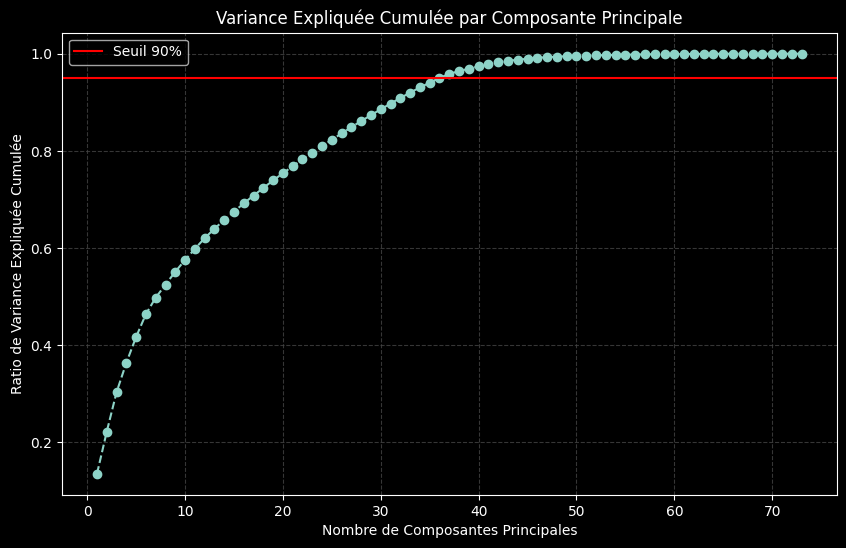

Nombre de composantes choisi pour expliquer 95% de la variance : 36
Dimensions initiales : (30494, 74)
Dimensions après PCA : (30494, 37)


,sample_id,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36
0,0,-2.961015,-0.489817,1.675453,0.088012,-1.546884,-1.103036,2.065247,-0.186913,-1.187330,...,0.759487,0.513097,0.335739,0.242389,-0.598944,0.012912,-0.492399,0.132929,-0.214201,1.074837
1,1,-0.410635,-2.534660,0.796999,-0.797266,1.426195,-1.103441,-0.303904,0.311116,-0.795300,...,0.581012,1.616301,0.501395,-0.700641,2.188266,-0.203527,0.518290,-0.793588,1.095515,0.587158
2,2,0.164924,-2.777125,0.630072,-2.403552,0.312779,-1.752040,0.140637,2.483960,0.703244,...,1.803918,0.972017,1.896678,-0.740275,0.078117,0.427856,-1.129863,-0.656931,-0.363202,1.139614
3,3,0.167062,-1.930160,1.092997,0.893839,1.049082,-1.567087,0.797966,1.938113,0.195077,...,0.292295,0.924007,0.075806,-0.651257,1.974494,-0.035546,-1.192315,-0.254525,1.136958,0.746637
4,4,-1.734711,-1.886842,1.027935,0.962792,1.458502,-0.523028,0.170808,-0.406199,-1.204964,...,0.870419,-1.206242,1.110360,-0.656584,0.105205,-0.287923,0.563739,-1.113512,0.710591,0.672528


In [9]:
# Réduction de dimension avec PCA
id_column = x_train_final['sample_id']
feature_cols = x_train_final.columns.difference(['sample_id'])

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_final[feature_cols])
x_train_scaled = pd.DataFrame(x_train_scaled, columns=feature_cols)

pca_full = PCA()
pca_full.fit(x_train_scaled)

# calcul de la variance expliquée cumulée
explained_variance_ratio_cumsum = np.cumsum(pca_full.explained_variance_ratio_)

# Graphique de la variance expliquée cumulée pour la méthode du coude
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio_cumsum) + 1), explained_variance_ratio_cumsum, marker='o', linestyle='--')
plt.title('Variance Expliquée Cumulée par Composante Principale')
plt.xlabel('Nombre de Composantes Principales')
plt.ylabel('Ratio de Variance Expliquée Cumulée')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='-', label='Seuil 90%')
plt.legend()
plt.show()

n_components = np.where(explained_variance_ratio_cumsum >= 0.95)[0][0] + 1
print(f"Nombre de composantes choisi pour expliquer 95% de la variance : {n_components}")

pca_final = PCA(n_components=n_components)
x_train_pca = pca_final.fit_transform(x_train_scaled)

pca_cols = [f'PC{i+1}' for i in range(n_components)]
x_train_pca = pd.DataFrame(data=x_train_pca, columns=pca_cols)
x_train_pca.insert(0, 'sample_id', id_column.values)

# Afficher les premières lignes du résultat
print(f"Dimensions initiales : {x_train_final.shape}")
print(f"Dimensions après PCA : {x_train_pca.shape}")

display(x_train_pca.head())

In [10]:
id_column_test = x_test_final['sample_id']
feature_cols = x_train_final.columns.difference(['sample_id'])

x_test_scaled = scaler.transform(x_test_final[feature_cols])
x_test_pca = pca_final.transform(x_test_scaled)

x_test_pca = pd.DataFrame(data=x_test_pca, columns=pca_cols)
x_test_pca.insert(0, 'sample_id', id_column_test.values)

print(f"Dimensions initiales de x_test : {x_test_final.shape}")
print(f"Dimensions après PCA de x_test : {x_test_pca.shape}")

display(x_test_pca.head())

Dimensions initiales de x_test : (13133, 74)
Dimensions après PCA de x_test : (13133, 37)


,sample_id,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36
0,30744,7.041206,1.597151,-0.903839,0.424630,1.874398,-1.341605,1.419034,0.216118,1.058757,...,-1.683932,-0.896684,1.119795,2.487869,-0.290826,2.239825,1.269598,-0.632413,-0.499097,-0.803112
1,30745,4.155440,1.787758,-0.818056,0.784331,-0.226107,-2.045167,1.910779,-0.059483,0.544272,...,1.059767,-0.003753,-1.083195,-0.689127,-1.262168,-1.141110,0.072283,-1.067567,0.021836,-0.872861
2,30746,6.553627,1.451544,-0.825900,2.704769,0.319641,-3.163760,-0.614337,-1.177692,-0.637268,...,1.085634,-0.564748,-1.572955,-1.158409,-1.635126,-0.899919,2.232673,0.478223,0.535987,-1.275820
3,30747,1.220688,0.714823,-1.232939,0.965589,0.356622,-1.243360,1.097226,-1.361909,0.049409,...,-0.073600,-0.303629,-1.068678,-0.129512,0.497704,-0.115054,0.799395,-0.080176,-0.668746,-0.469976
4,30748,3.891117,0.382126,-1.262636,-0.328923,0.507487,-1.872621,-0.439576,-1.496251,0.034568,...,1.487428,0.029913,0.030656,0.845534,0.215880,0.511841,-0.070153,1.215413,0.334238,-0.548506


---

## 3. Modèles

### 3.1 Méhtodologie

Le modèle est entraîné sur **x_train** et **y_train**, qui constituent le **Within-Sample (WS)**, c’est-à-dire les données utilisées pour ajuster les paramètres et apprendre les éventuels patterns. 

On réserve **x_test** comme **Out-Of-Sample (OOS)**, un jeu de données jamais vu par le modèle, pour évaluer sa capacité de généralisation. 

Les performances WS servent à contrôler l’apprentissage et à ajuster les hyperparamètres, tandis que les prédictions OOS permettent de mesurer la robustesse du modèle sur de nouvelles observations, sans risque de **data leakage**.

La métrique RMSE sur les données out of sample n'est donnée qu'un fois la soumission des résultats réalisée sur le site https://challengedata.ens.fr/participants/challenges/71

### 3.2 XGBoost

In [26]:
X = x_train_pca.drop(['sample_id'], axis=1)
Y = y_train['target']

model = xgb.XGBRegressor()
hyperparameter_grid = {
    'n_estimators': [200, 400, 500, 600],
    'max_depth': [3, 4, 6, 10],
    'learning_rate': [0.03, 0.045, 0.05, 0.055],
    'min_child_weight': [1, 3, 5, 10],
    'subsample': [0.5, 0.6, 0.75],
    'colsample_bytree': [0.5, 0.6, 0.75],
    'gamma': [0, 0.1, 0.2],
    'reg_lambda': [0, 0.1, 0.3],
    'alpha': [0, 0.1, 0.3],
    'tree_method': ['hist']
}

cv = TimeSeriesSplit(n_splits=3)

random_cv = RandomizedSearchCV(
    estimator=model,
    param_distributions=hyperparameter_grid, 
    cv=cv, 
    n_iter=100,
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1,
    return_train_score=True, 
    verbose=0,
    random_state=42
    )

random_cv.fit(X, Y)

,estimator,"XGBRegressor(...ree=None, ...)"
,param_distributions,"{'alpha': [0, 0.1, ...], 'colsample_bytree': [0.5, 0.6, ...], 'gamma': [0, 0.1, ...], 'learning_rate': [0.03, 0.045, ...], ...}"
,n_iter,100
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,TimeSeriesSpl...est_size=None)
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


----- Résultats du modèle XGBoost -----
Meilleur score RMSE: 0.00915290
Meilleurs paramètres: {'tree_method': 'hist', 'subsample': 0.75, 'reg_lambda': 0, 'n_estimators': 600, 'min_child_weight': 5, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.5, 'alpha': 0}


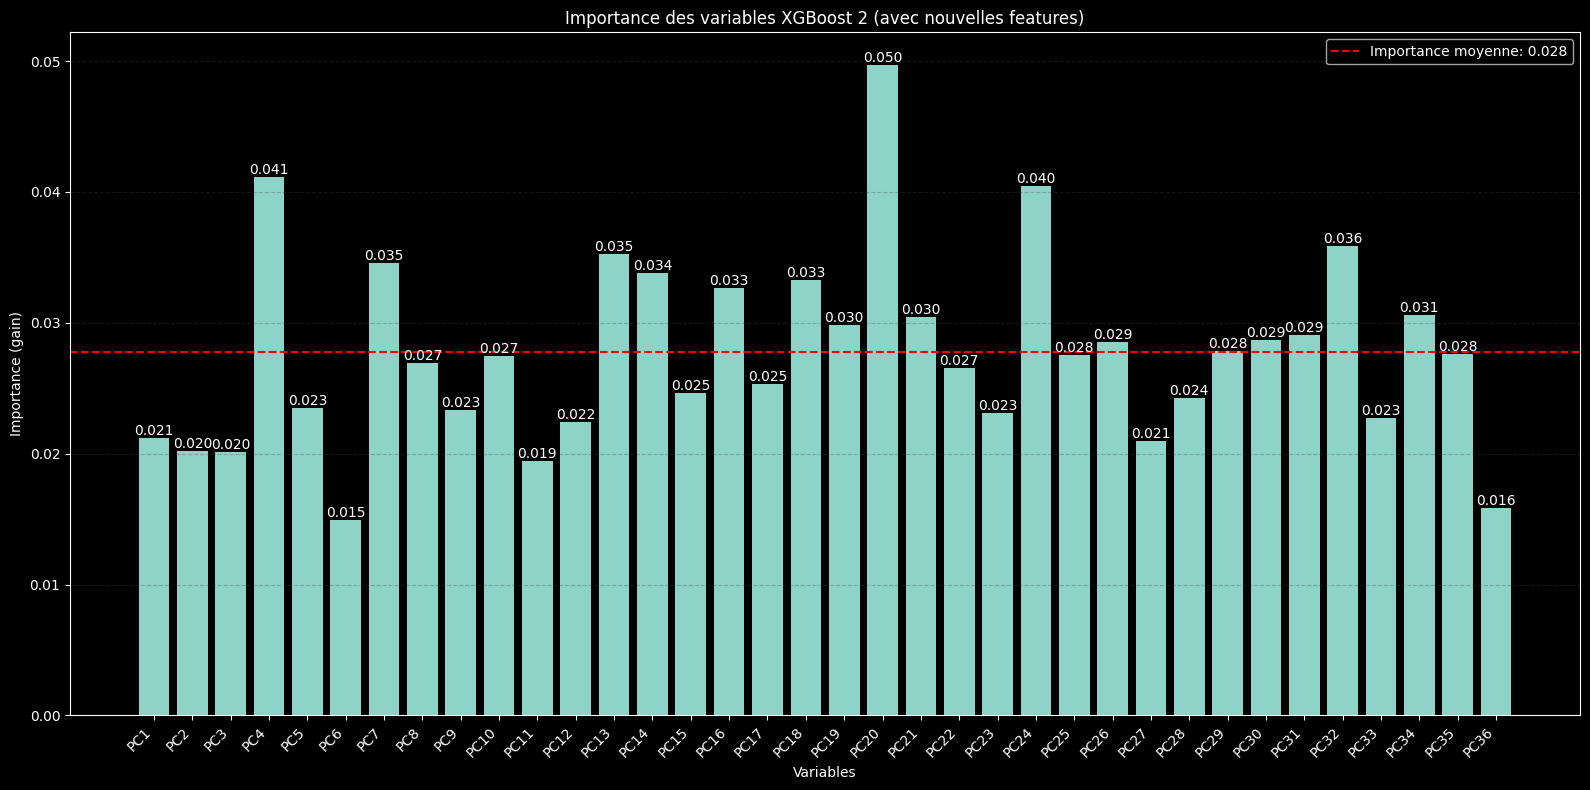

In [27]:
feature_importances = random_cv.best_estimator_.feature_importances_
features = X.columns

plt.figure(figsize=(16, 8))
bars = plt.bar(features, feature_importances)
plt.title('Importance des variables XGBoost 2 (avec nouvelles features)')
plt.xlabel('Variables')
plt.ylabel('Importance (gain)')
plt.xticks(rotation=45, ha='right')

mean_importance = np.mean(feature_importances)
plt.axhline(y=mean_importance, color='red', linestyle='--', 
            label=f'Importance moyenne: {mean_importance:.3f}')
plt.legend()
plt.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom')

print("----- Résultats du modèle XGBoost -----")
print(f"Meilleur score RMSE: {-random_cv.best_score_:.8f}")
print("Meilleurs paramètres:", random_cv.best_params_)

plt.tight_layout()
plt.show()

In [28]:
X_test = x_test_pca.drop("sample_id", axis=1)
y_pred = random_cv.best_estimator_.predict(X_test)
submission = pd.DataFrame({
    'sample_id': x_test_pca['sample_id'],
    'target': y_pred
})

print("Aperçu du fichier de soumission :")
display(submission.head())

submission.to_csv('output/y_test_xgb_pca.csv', index=False)

Aperçu du fichier de soumission :


,sample_id,target
0,30744,-0.000031
1,30745,-0.002932
2,30746,0.003629
3,30747,0.000701
4,30748,0.003422
